## Exploración de la relación entre las entrega de las primeras actividades con el abandono

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display
import numpy as np
import os


PATH_SOURCE_DATASETS = "/home/carlos/Documentos/TFG/spark-workspace/data/datasets"


## Carga de datos y filtrado

In [5]:
df = pd.read_parquet(os.path.join(PATH_SOURCE_DATASETS, "dataset_4.0.parquet"))

# display(df.head())

# print(df.info())
      
columns_to_keep = ["Act. 02 - Elecciones", "Act. 03 - Catalan", "Act. 04 - Primos", "abandona"]
df = df[columns_to_keep]

display(df.head())
print(df.info())



,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,abandona
0,1,1,1,0
1,1,1,1,0
2,1,1,1,1
3,1,1,1,0
4,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Act. 02 - Elecciones  201 non-null    int32
 1   Act. 03 - Catalan     201 non-null    int32
 2   Act. 04 - Primos      201 non-null    int32
 3   abandona              201 non-null    int32
dtypes: int32(4)
memory usage: 3.3 KB
None


## Visualizaciones

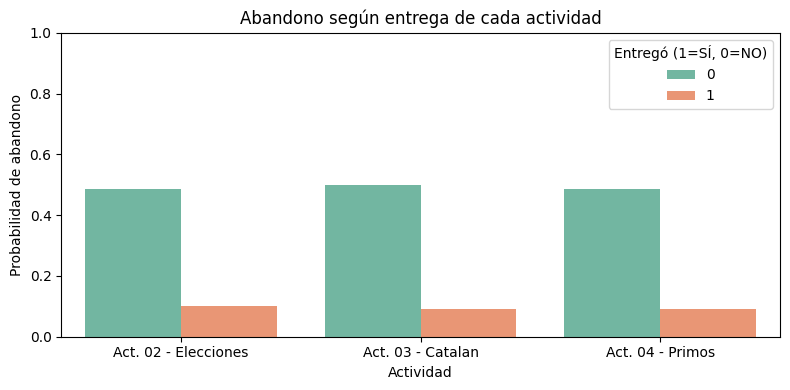

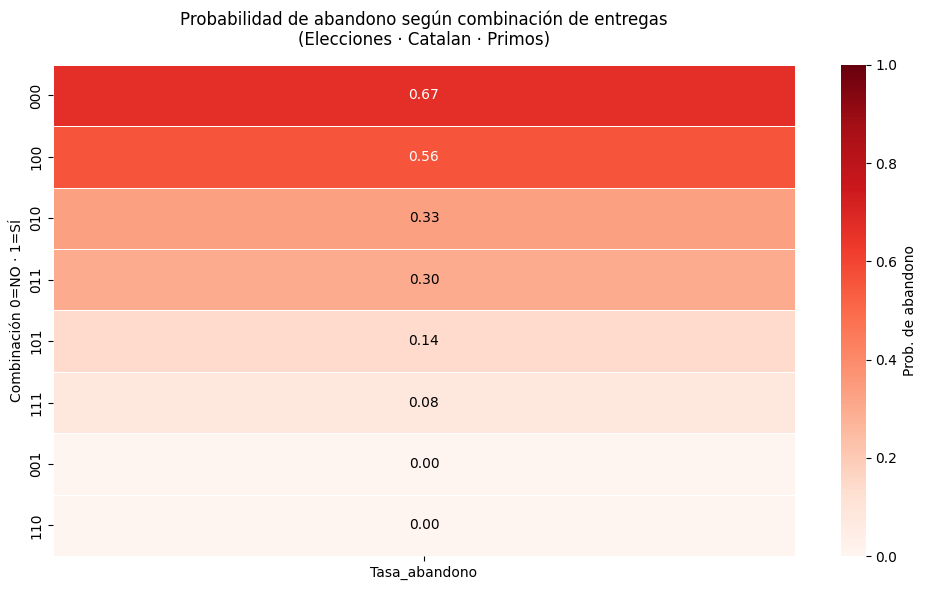

In [7]:
# %% [markdown]
# ## 📊 Relación entre la entrega de actividades y el abandono
# 
# En esta celda:
# 1. Calculamos, para cada actividad, la **tasa de abandono** cuando *no se entrega* (0) frente a cuando *sí se entrega* (1).
# 2. Dibujamos un **gráfico de barras agrupadas** con esas tasas.
# 3. Mostramos un **heat-map** con la probabilidad de abandono para **cada combinación posible** de entregas (000, 001, …, 111).

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- asegúrate de tener el DataFrame 'df' ya cargado ---
# columnas de interés
acts = ["Act. 02 - Elecciones", "Act. 03 - Catalan", "Act. 04 - Primos"]

# ═══════════════════════════════════════════════════════════════════════
# 1) Tasa de abandono por actividad y estado de entrega
# ═══════════════════════════════════════════════════════════════════════
summary = (
    df
    .melt(id_vars="abandona", value_vars=acts,
          var_name="Actividad", value_name="Entregó")
    .groupby(["Actividad", "Entregó"])["abandona"]
    .mean()                          # probabilidad media de abandono
    .reset_index(name="Tasa_abandono")
)

# ═══════════════════════════════════════════════════════════════════════
# 2) Gráfico de barras agrupadas
# ═══════════════════════════════════════════════════════════════════════
plt.figure(figsize=(8,4))
sns.barplot(data=summary, x="Actividad", y="Tasa_abandono",
            hue="Entregó", palette="Set2")
plt.ylim(0,1)
plt.ylabel("Probabilidad de abandono")
plt.title("Abandono según entrega de cada actividad")
plt.legend(title="Entregó (1=SÍ, 0=NO)")
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════
# 3) Heat-map por combinación de entregas (000-111)
# ═══════════════════════════════════════════════════════════════════════
acts = ["Act. 02 - Elecciones", "Act. 03 - Catalan", "Act. 04 - Primos"]

# 1) Construimos la columna 'combo' (p.e. '101')
df_combo = df.copy()
df_combo["combo"] = (
    df_combo[acts].astype(str).agg("".join, axis=1)
)

# 2) Calculamos la tasa de abandono por combinación
heat = (
    df_combo.groupby("combo")["abandona"].mean()
    .rename("Tasa_abandono").to_frame()
)

# 3) Ordenamos las filas por “peor a mejor” (mayor tasa primero)
heat = heat.sort_values("Tasa_abandono", ascending=False)

# 4) Dibujamos el heat-map
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heat,
    cmap="Reds",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Prob. de abandono"}
)

# Ajuste visual de anotaciones (texto claro en celdas oscuras)
for t in ax.texts:
    val = float(t.get_text())
    t.set_color("white" if val > 0.5 else "black")

ax.set_title("Probabilidad de abandono según combinación de entregas\n"
             "(Elecciones · Catalan · Primos)", pad=14)
ax.set_xlabel("")            # sin etiqueta porque ya está en el título
ax.set_ylabel("Combinación 0=NO · 1=SÍ")
plt.tight_layout()
plt.show()